In [2]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [22]:
wavenumber = 0.4
#h = 0.05

In [3]:
two_branches = bempp.api.import_grid('6branches.msh')
space_two_branches = bempp.api.function_space(two_branches,'P',1)

In [4]:
two_branches.vertices.shape

(3, 13143)

In [7]:
max((two_branches.vertices)[1,:])

1.0

In [9]:
(bempp.api.shapes.sphere(r = 1, h=0.05, origin=(-((0.5/2) + 1), 0, 0))).vertices.shape

(3, 6306)

In [23]:
unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

In [24]:
eta = wavenumber

identity2 = bempp.api.operators.boundary.sparse.identity(space_two_branches, space_two_branches,space_two_branches)
slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
slp_far2 = helmholtz_farfield.single_layer(space_two_branches, vert_unit_sphere, wavenumber)
dlp_far2 = helmholtz_farfield.double_layer(space_two_branches, vert_unit_sphere,wavenumber)

lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

In [16]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

d = [1,0,0]

def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)/(-1)**(abs(p))
    return coeff

def sca_far_field(x):
    fun = 0
    i = 0
    for q in range(deg+1):
        for p in range(-q,q+1):
            fun += coeff_sca[i]*(1/wavenumber)*(-1j)**(q+1) * normalized_spherical_harmonics(p, q, x)
            i +=1
    return fun

In [25]:
for deg in [5,10,15]:
    sph_harm_coeff = []
    slp_far_field_coeff = []
    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def sph_harm(x,n,domain_index,result):
                with objmode():
                    result[0] = normalized_spherical_harmonics(p,q,x)
            sph_harm_grid = bempp.api.GridFunction(space_unit_sphere,fun = sph_harm)
            sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun = bempp.api.GridFunction(space_two_branches, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs2, rhs_fun, tol=1E-5)
            slp_far_field_coeff.append(dlp_far2.evaluate(field) - 1j * eta * slp_far2.evaluate(field))

    mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere,space_unit_sphere,space_unit_sphere).weak_form().A

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    coeff_inc = []
    for q in range(deg+1):
        for p in range(-q, q+1):
            coeff_inc.append(coeff_sph_expansion(p,q))

    coeff_sca = T_matrix @ coeff_inc

    far_list_test = []
    for i in range(vert_unit_sphere.shape[1]):
        far_list_test.append(sca_far_field(vert_unit_sphere[:,i]))

    @bempp.api.complex_callable
    def exact_data(x, n, domain_index, result):
        with objmode():
            result[0] = - np.exp(1j * wavenumber * (x[0]*d[0]+x[1]*d[1]+x[2]*d[2]))

    grid_fun = bempp.api.GridFunction(space_two_branches, fun=exact_data)
    fun_exact, info_exact = bempp.api.linalg.gmres(lhs2, grid_fun, tol=1E-5)
    res_exact = dlp_far2.evaluate(fun_exact) - 1j * eta * slp_far2.evaluate(fun_exact)
    err = np.sqrt((far_list_test - res_exact[0,:]) @ mass_mat @ np.conj(far_list_test - res_exact[0,:]))/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]))

    print(deg,err)

5 (0.0006679143851854897-4.9247249508021934e-21j)
10 (0.0006679822955916417-6.967549401684789e-21j)
15 (0.000668066971032043-7.330682103643026e-21j)


In [ ]:
#direction is d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
0.2 5 (0.007351923435187111+2.3590972205251136e-20j)
0.2 10 (0.00759277833696626+1.1271393420564968e-21j)
0.2 15 (0.007588186874124422-1.9185535296060087e-20j)

0.1 5 (0.0018627313019147786-9.30902747367178e-22j)
0.1 10 (0.0018639878945194862-9.176452131303642e-22j)
0.1 15 (0.0018658758802338464-8.977438132244697e-22j)

0.05 5 (0.00037498540263131716-1.483299909234925e-21j)
0.05 10 (0.00037510620312701184-8.85837062506242e-22j)
0.05 15 (0.0003752609281838623-8.975673747944221e-23j)

In [ ]:
#direction is d = [0,0,1]

0.2 5 (0.008001532970792676+0j)
0.2 10 (0.008014214040109836+0j)
0.2 15 (0.00800895248220308+0j)

0.1 5 (0.002294901400350088+0j)
0.1 10 (0.002295903053736612-8.351305342504683e-21j)
0.1 15 (0.0022972983566295234+1.669246607277791e-20j)

0.05 5 (0.0008076552727085955+9.04292323953326e-21j)
0.05 10 (0.0008077094880485937+1.0524517475701347e-20j)
0.05 15 (0.0008077788430789625+9.043400204245478e-21j)

In [ ]:
#direction is d = [1,0,0]

0.2 5 (0.007874839660089122+0j)
0.2 10 (0.007888471191150935+0j)
0.2 15 (0.007883560157738046+0j)

0.1 5 (0.002154148329854347-4.33099895481891e-20j)
0.1 10 (0.002155215218119084-4.333143975148033e-20j)
0.1 15 (0.0021568029065670248-7.803333004995576e-21j)

0.05 5 (0.0006679143851854897-4.9247249508021934e-21j)
0.05 10 (0.0006679822955916417-6.967549401684789e-21j)

In [26]:
x_axis = [5, 10, 15]

#direction is d = [1,0,0]
d1_02 = [0.007874839660089122, 0.007888471191150935, 0.007883560157738046]
d1_01 = [0.002154148329854347, 0.002155215218119084, 0.0021568029065670248]
d1_005 = [0.0006679143851854897, 0.0006679822955916417, 0.000668066971032043]

#direction is d = [0,0,1]
d2_02 = [0.008001532970792676, 0.008014214040109836, 0.00800895248220308]
d2_01 = [0.002294901400350088, 0.002295903053736612, 0.0022972983566295234]
d2_005 = [0.0008076552727085955, 0.0008077094880485937, 0.0008077788430789625]

#direction is d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
d3_02 = [0.007351923435187111, 0.00759277833696626, 0.007588186874124422]
d3_01 = [0.0018627313019147786, 0.0018639878945194862, 0.0018658758802338464]
d3_005 = [0.00037498540263131716, 0.00037510620312701184, 0.0003752609281838623]

<Figure size 432x288 with 0 Axes>

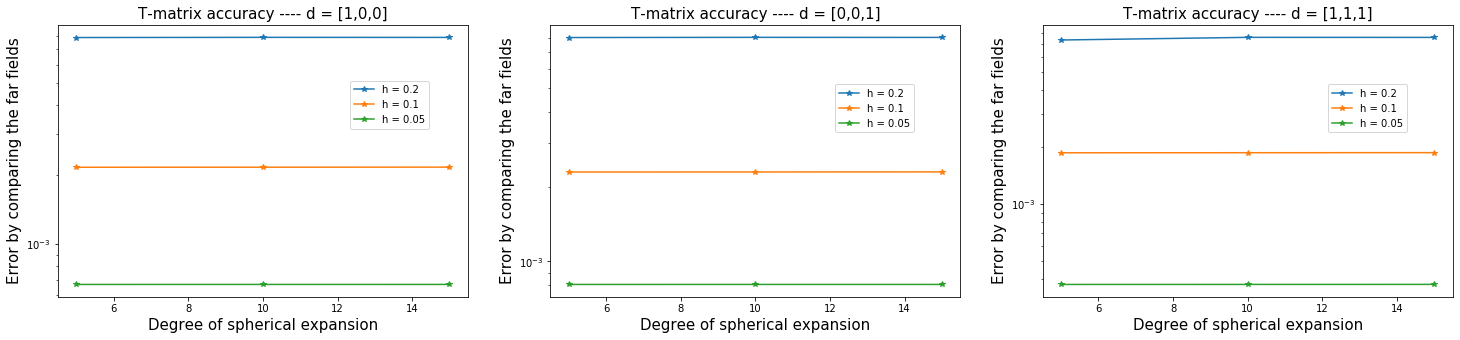

In [27]:
fig = plt.figure()
plt.figure(figsize = (25,5))
plt.subplot(1,3,1)
plt.semilogy(x_axis,d1_02,'*-')
plt.semilogy(x_axis,d1_01,'*-')
plt.semilogy(x_axis,d1_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'],  bbox_to_anchor=(0.7,0.6))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [1,0,0]',fontsize = 15)

plt.subplot(1,3,2)
plt.semilogy(x_axis,d2_02,'*-')
plt.semilogy(x_axis,d2_01,'*-')
plt.semilogy(x_axis,d2_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'], bbox_to_anchor=(0.9,0.8))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [0,0,1]',fontsize = 15)

plt.subplot(1,3,3)
plt.semilogy(x_axis,d3_02,'*-')
plt.semilogy(x_axis,d3_01,'*-')
plt.semilogy(x_axis,d3_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'], bbox_to_anchor=(0.9,0.8))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [1,1,1]',fontsize = 15)
plt.savefig('six branches T matrix accuracy.pdf',bbox_inches='tight')